In [3]:
"""Sanity check on booth function. All optimizers should converge."""
import pytest
import torch
import numpy as np
import torchzero as tz

def booth(x,y):
    return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

x0 = (0, -8)

__pylance = torch.tensor(float('inf'))
PRINT_LOSSES = True

def _ensure_float(x):
    if isinstance(x,torch.Tensor): return x.detach().cpu().item()
    if isinstance(x, np.ndarray): return x.item()
    return x

def _test_optimizer(lmbda, tol=1e-1, niter=100, allow_non_tensor=False):
    params = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
    opt = lmbda([params])
    
    def closure(backward=True):
        loss = booth(*params)
        if backward:
            opt.zero_grad()
            loss.backward()
        return loss
    
    loss = __pylance
    losses = []
    for i in range(niter):
        loss = opt.step(closure)
        losses.append(loss)
        
        if allow_non_tensor: 
            assert isinstance(loss, (torch.Tensor, np.ndarray, int, float)), (opt.__class__.__name__, i, type(loss), loss)
        else:
            assert isinstance(loss, torch.Tensor), (opt.__class__.__name__, i, type(loss), loss)
    
        if isinstance(loss, torch.Tensor): assert torch.isfinite(loss), (opt.__class__.__name__, i, loss)
        else: assert np.isfinite(loss), (opt.__class__.__name__, i, loss)
        
    assert loss <= tol, (opt.__class__.__name__, tol, loss, [i.detach().cpu().item() for i in losses])
    if PRINT_LOSSES: print(opt.__class__.__name__, _ensure_float(loss))

In [60]:
from torchzero.core import OptimizerModule
from torchzero.tensorlist import TensorList

def _program_5_(w: TensorList, g: TensorList, m: TensorList, v: TensorList, lr: TensorList):
    """taken from https://arxiv.org/abs/2302.06675"""
    m.lerp_(g, 0.16)
    g2 = g ** 2
    v.lerp_(g2, 0.001)
    v753 = (g*w).total_sum()
    sqrt_v = v.sqrt()
    update = m / sqrt_v
    wd = v753 * w
    update.sin_()
    update.add_(wd)
    lr = lr * -0.0216
    update.mul_(lr)
    v.sin_()
    return update

class LionOther5(OptimizerModule):
    def __init__(self, lr:float=1):
        super().__init__({"lr": lr})
        
    def _update(self, state, ascent):
        m, v = self.get_state_keys(('m', 'v'))
        lr = self.get_group_key('lr')
        params = self.get_params()
        
        return _program_5_(params, ascent, m, v, lr)

TensorList([tensor([[0.0285, 0.0154],
        [0.2221, 0.0109],
        [0.1138, 0.0006],
        [0.1650, 0.0006],
        [0.0797, 0.0000],
        [0.0202, 0.0076],
        [0.0038, 0.0569],
        [0.0266, 0.0076],
        [0.0000, 0.0101],
        [0.0456, 0.0101],
        [0.0161, 0.0116],
        [0.0218, 0.0226],
        [0.0050, 0.0229],
        [0.0000, 0.0456]])])
TensorList([tensor([[   nan, 0.0218],
        [   nan, 0.0154],
        [   nan, 0.0008],
        [   nan, 0.0008],
        [   nan, 0.0000],
        [   nan, 0.0107],
        [0.0053,    nan],
        [   nan, 0.0107],
        [0.0000,    nan],
        [   nan,    nan],
        [   nan,    nan],
        [   nan,    nan],
        [0.0071,    nan],
        [0.0000,    nan]])])
TensorList([tensor([[   nan, 0.0218],
        [   nan, 0.0154],
        [   nan, 0.0008],
        [   nan, 0.0008],
        [   nan, 0.0000],
        [   nan, 0.0107],
        [0.0053,    nan],
        [   nan, 0.0107],
        [0.0000,    na

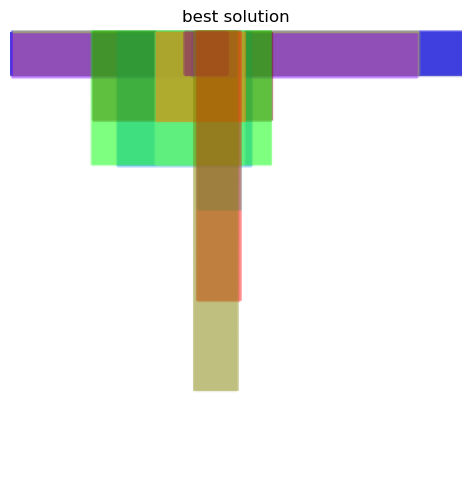

In [61]:
from visualbench.tasks.box_packing import BoxPacking

f = BoxPacking()
opt = lambda p: tz.optim.Modular(p, LionOther5(1e-5))
f.run(opt(f.parameters()), 100)
f.plot_solution()

In [16]:
import nevergrad as ng
from torchzero.optim.wrappers.nevergrad import NevergradOptimizer
opt = lambda p: NevergradOptimizer(p, ng.optimizers.OnePlusOne, budget=500)
_test_optimizer(opt, niter=500, allow_non_tensor=True)        

NevergradOptimizer 2.2737367544323206e-13


In [1]:
import nlopt

In [2]:
import importlib.util
importlib.util.find_spec('nlopt')

ModuleSpec(name='nlopt', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f585ced12e0>, origin='/var/home/jj/distrobox/arch/miniconda3/envs/pytorch312/lib/python3.12/site-packages/nlopt.py')

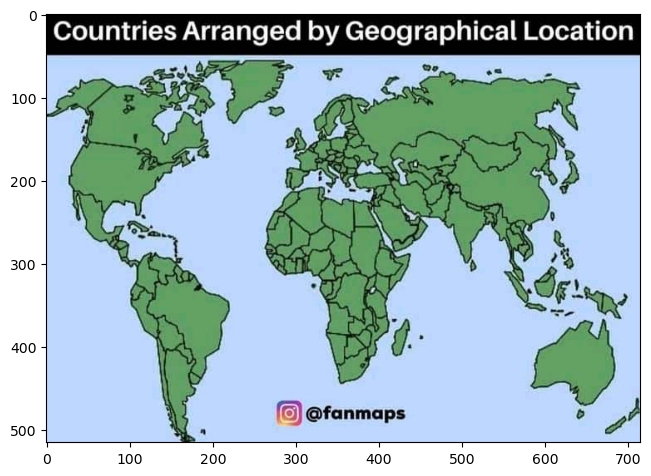

In [1]:
from myai.imports import *
grad = imreadtensor(r'/var/mnt/ssd/Файлы/Изображения/Мемы/countries.jpg')
imshow(grad).show()

In [3]:
import torch

def whiten(X,fudge=1E-18):

   # the matrix X should be observations-by-components

   # get the covariance matrix
   Xcov = torch.vmap(torch.dot, tuple(range(X.ndim - 1)))(X.T,X)

   # eigenvalue decomposition of the covariance matrix
   d, V = torch.linalg.eigh(Xcov)

   # a fudge factor can be used so that eigenvectors associated with
   # small eigenvalues do not get overamplified.
   D = torch.diag(1. / torch.sqrt(d+fudge))

   # whitening matrix
   W = torch.dot(torch.dot(V, D), V.T)

   # multiply by the whitening matrix
   X_white = torch.dot(X, W)

   return X_white, W

X_white, W = whiten(grad)

ValueError: vmap: Expected all tensors to have the same size in the mapped dimension, got sizes [715, 515] for the mapped dimension